## **Customer Segmentation**

# **Import Libraries**

In [76]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as py
import seaborn as sb

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

# **Load Data**

In [77]:
traindt = pd.read_csv('Train.csv', index_col='ID')
trainCluster = traindt['Segmentation']
traindt.drop(['Segmentation'], axis=1, inplace=True)

testdt = pd.read_csv('Test.csv', index_col='ID')
testCluser = pd.read_csv('sample_submission.csv', index_col='ID')

# **Exploratory Data Analysis**

In [78]:
traindt.head(10)

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
ID,,,,,,,,,
462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4
462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4
466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6
461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6
462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6
461319,Male,Yes,56,No,Artist,0.0,Average,2.0,Cat_6
460156,Male,No,32,Yes,Healthcare,1.0,Low,3.0,Cat_6
464347,Female,No,33,Yes,Healthcare,1.0,Low,3.0,Cat_6
465015,Female,Yes,61,Yes,Engineer,0.0,Low,3.0,Cat_7


In [79]:
traindt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8068 entries, 462809 to 461879
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           8068 non-null   object 
 1   Ever_Married     7928 non-null   object 
 2   Age              8068 non-null   int64  
 3   Graduated        7990 non-null   object 
 4   Profession       7944 non-null   object 
 5   Work_Experience  7239 non-null   float64
 6   Spending_Score   8068 non-null   object 
 7   Family_Size      7733 non-null   float64
 8   Var_1            7992 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 630.3+ KB


In [80]:
pd.DataFrame({'missing':traindt.isnull().sum(),
              'percentage':(traindt.isnull().sum() / np.shape(traindt)[0]) * 100})

,missing,percentage
Gender,0,0.000000
Ever_Married,140,1.735250
Age,0,0.000000
Graduated,78,0.966782
Profession,124,1.536936
Work_Experience,829,10.275161
Spending_Score,0,0.000000
Family_Size,335,4.152206
Var_1,76,0.941993


In [81]:
traindt.describe()

,Age,Work_Experience,Family_Size
count,8068.000000,7239.000000,7733.000000
mean,43.466906,2.641663,2.850123
std,16.711696,3.406763,1.531413
min,18.000000,0.000000,1.000000
25%,30.000000,0.000000,2.000000
50%,40.000000,1.000000,3.000000
75%,53.000000,4.000000,4.000000
max,89.000000,14.000000,9.000000


In [82]:
(len(np.unique(traindt.Work_Experience)) - 1, len(np.unique(traindt.Family_Size)) - 1)

(15, 9)

**Working with Features**

In [83]:
def plot_category(categorical, contenious= traindt.Age, target= trainCluster):
   rn: None


   sb.set_theme(style='ticks')
   py.figure(figsize=(10, 5))
   py.title("Count of each value in " + categorical.name)
   sb.countplot(x=categorical, hue=target); py.show()

   sb.set_theme(style='darkgrid')
   py.figure(figsize=(10, 5))
   py.title("Distribution of " + contenious.name + " based on " + categorical.name)
   sb.stripplot(x=categorical, y=contenious, hue=target); py.show()

   sb.set_theme(style='ticks')
   py.figure(figsize=(10, 5))
   py.title("Distribution of " + contenious.name + " based on " + categorical.name)
   sb.boxenplot(x=categorical, y=contenious, hue=target); py.show()

   pass

**Age**

<Axes: xlabel='Age', ylabel='Count'>

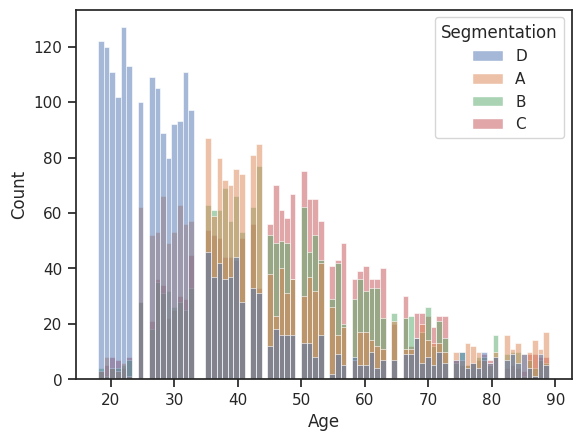

In [84]:
sb.histplot(x=traindt['Age'], hue=trainCluster, bins=80)

In [85]:
pd.DataFrame(data=[trainCluster[(traindt['Age'] >= 35) & (traindt['Age'] <= 45)].value_counts(),
                   trainCluster[(traindt['Age'] >= 35) & (traindt['Age'] <= 45)].value_counts() / trainCluster[(traindt['Age'] >= 35) &
                   (traindt['Age'] <= 45)].value_counts().sum() * 100], index=['Segmentation', 'Percentage'])

,A,B,C,D
Segmentation,722.000000,621.000000,484.000000,346.000000
Percentage,33.225955,28.578003,22.273355,15.922688


**Gender**

In [86]:
pd.DataFrame(data=[(trainCluster[(traindt['Gender'] == 'Male')].value_counts()/ trainCluster.value_counts()) * 100,
                   (trainCluster[(traindt['Gender'] == 'Female')].value_counts()/ trainCluster.value_counts()) * 100],
             index=['Male', 'Female'])

,D,A,C,B
Male,57.716049,53.904665,53.19797,53.659849
Female,42.283951,46.095335,46.80203,46.340151


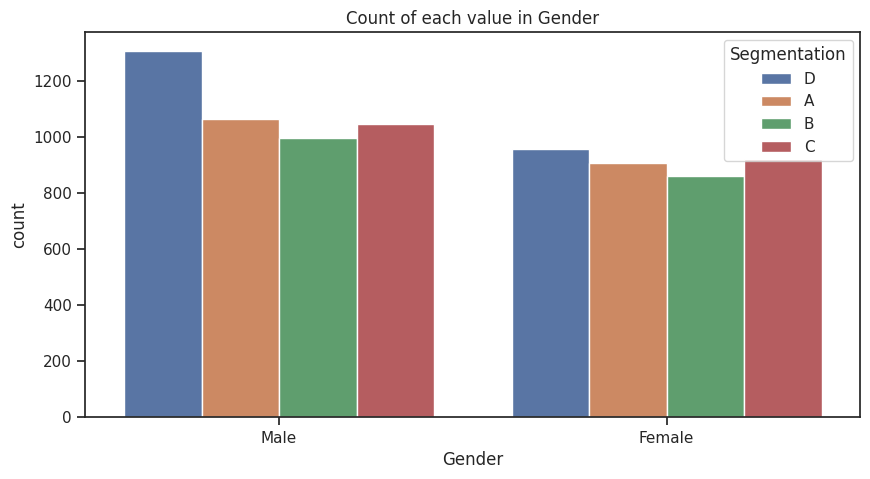

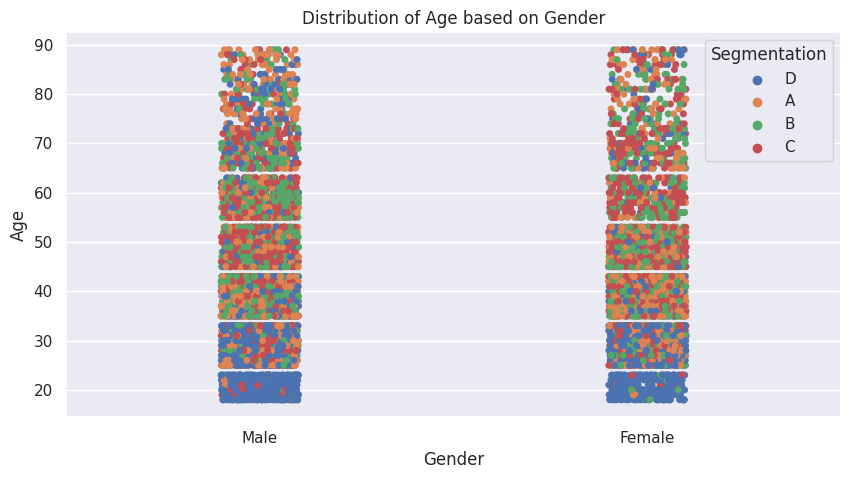

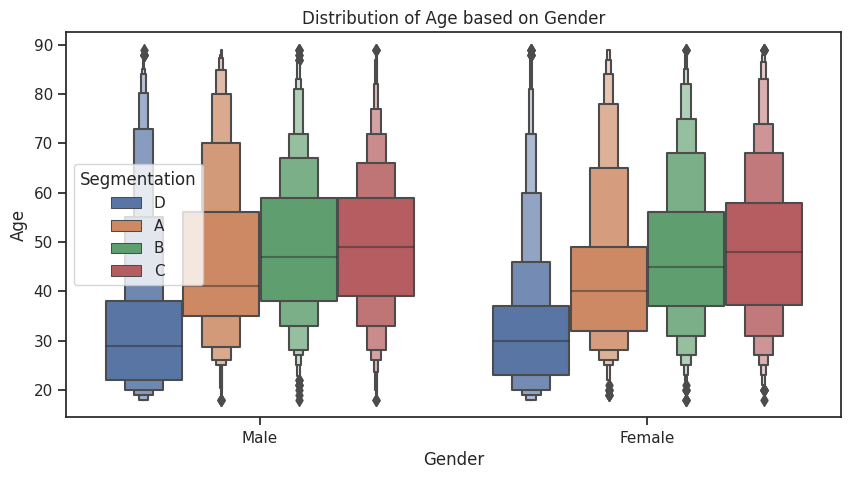

In [87]:
plot_category(categorical=traindt.Gender)

**Ever Married**

In [88]:
pd.DataFrame(data=[(trainCluster[(traindt['Ever_Married'] == 'No')].value_counts()/ trainCluster.value_counts()) * 100,
                   (trainCluster[(traindt['Ever_Married'] == 'Yes')].value_counts()/ trainCluster.value_counts()) * 100],
             index=['Not Married', 'Married'])

,A,B,C,D
Not Married,40.618661,25.780409,20.203046,70.855379
Married,57.657201,72.551130,78.629442,26.851852


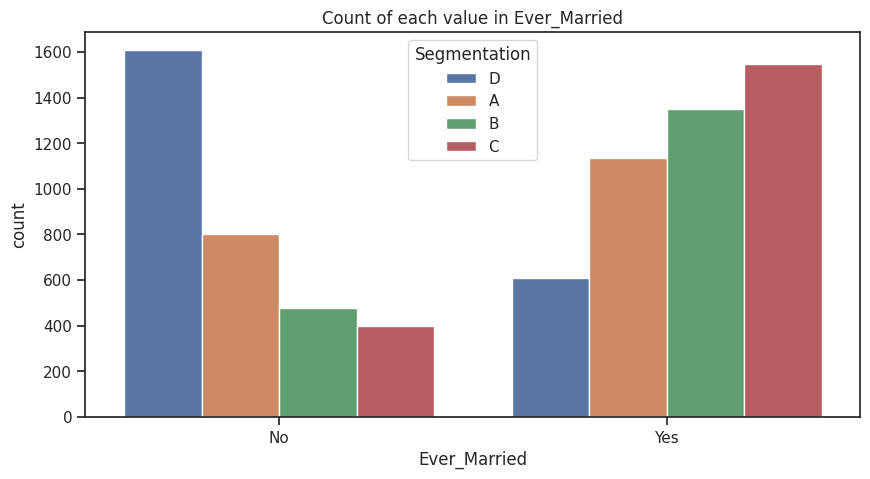

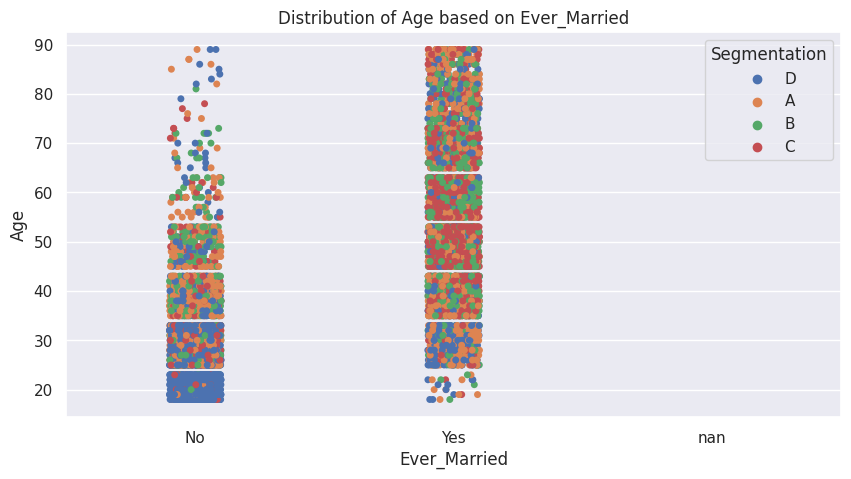

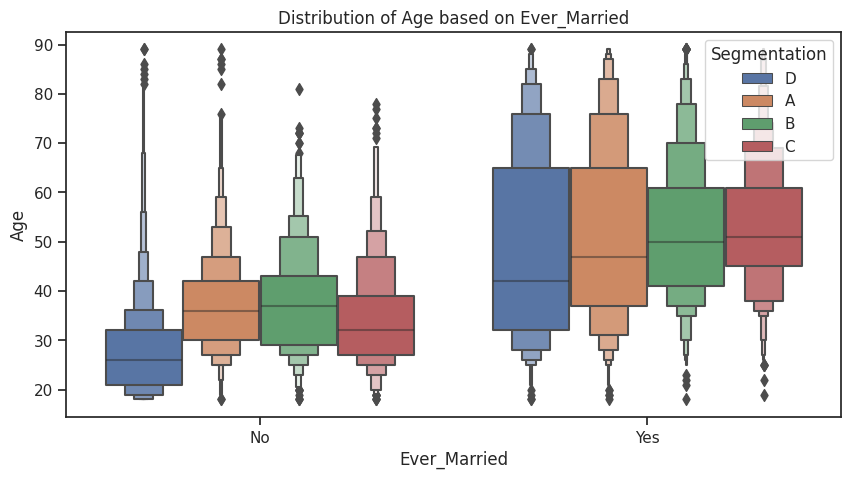

In [89]:
plot_category(categorical=traindt.Ever_Married)

**Graduated**

In [90]:
pd.DataFrame(data=[(trainCluster[(traindt['Graduated'] == 'No')].value_counts()/ trainCluster.value_counts()) * 100,
                   (trainCluster[(traindt['Graduated'] == 'Yes')].value_counts()/ trainCluster.value_counts()) * 100],
             index=['Not Graduated', 'Graduated'])

,A,B,C,D
Not Graduated,36.967546,27.341227,17.664975,63.359788
Graduated,61.815416,71.689989,81.573604,35.714286


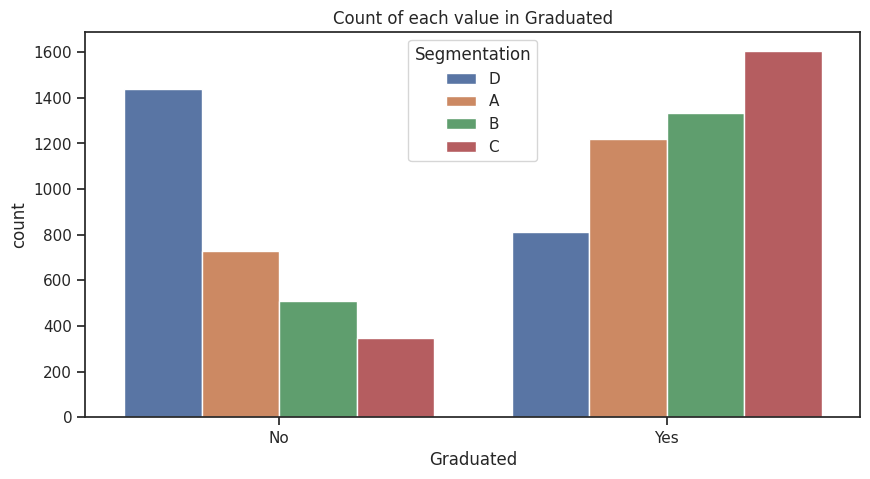

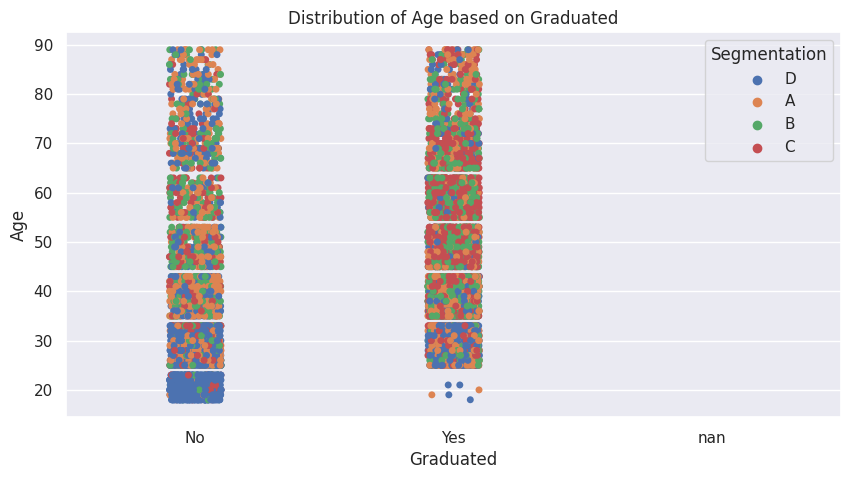

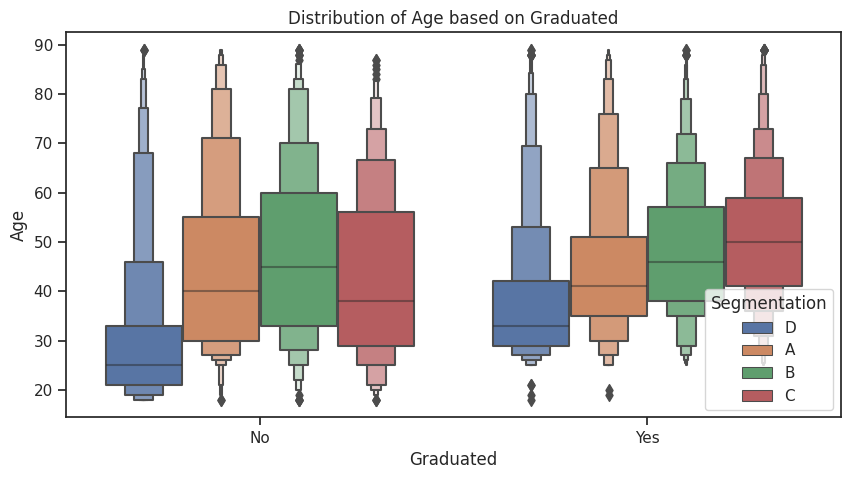

In [91]:
plot_category(categorical=traindt.Graduated)

**Profession**

In [92]:
traindt.Profession.unique()

array(['Healthcare', 'Engineer', 'Lawyer', 'Entertainment', 'Artist',
       'Executive', 'Doctor', 'Homemaker', 'Marketing', nan], dtype=object)

In [93]:
pd.DataFrame(data=[(trainCluster[(traindt['Profession'] == 'Healthcare')].value_counts()/ trainCluster.value_counts()) * 100,
                   (trainCluster[(traindt['Profession'] == 'Engineer')].value_counts()/ trainCluster.value_counts()) * 100,
                   (trainCluster[(traindt['Profession'] == 'Lawyer')].value_counts()/ trainCluster.value_counts()) * 100,
                   (trainCluster[(traindt['Profession'] == 'Entertainment')].value_counts()/ trainCluster.value_counts()) * 100,
                   (trainCluster[(traindt['Profession'] == 'Artist')].value_counts()/ trainCluster.value_counts()) * 100,
                   (trainCluster[(traindt['Profession'] == 'Executive')].value_counts()/ trainCluster.value_counts()) * 100,
                   (trainCluster[(traindt['Profession'] == 'Doctor')].value_counts()/ trainCluster.value_counts()) * 100,
                   (trainCluster[(traindt['Profession'] == 'Homemaker')].value_counts()/ trainCluster.value_counts()) * 100,
                   (trainCluster[(traindt['Profession'] == 'Marketing')].value_counts()/ trainCluster.value_counts()) * 100],
             index=traindt.Profession.unique()[:-1])

,A,B,C,D
Healthcare,5.375254,5.435953,7.411168,43.165785
Engineer,13.133874,10.172228,3.807107,7.760141
Lawyer,9.989858,8.503767,7.106599,5.643739
Entertainment,18.509128,11.894510,7.512690,9.479718
Artist,28.296146,40.688913,54.060914,6.040564
Executive,6.338742,9.849300,8.883249,5.114638
Doctor,10.091278,7.696448,7.106599,9.082892
Homemaker,3.701826,2.960172,1.421320,3.968254
Marketing,2.890467,1.614639,1.776650,7.495591


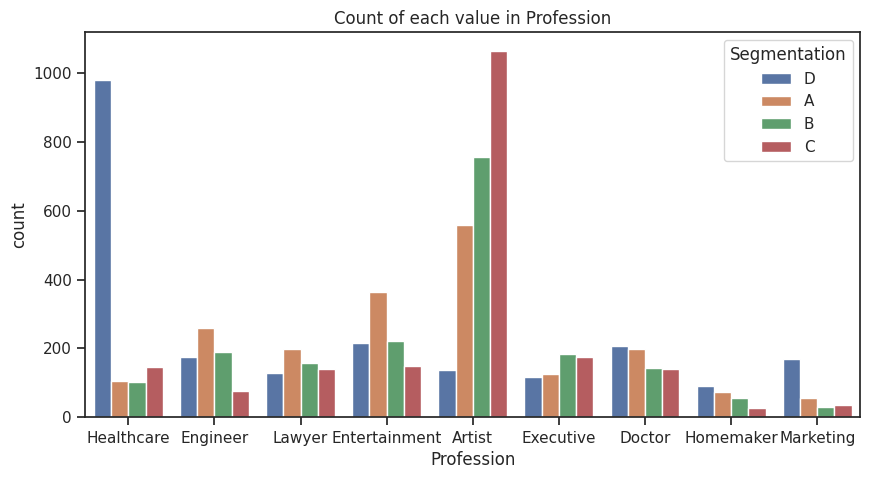

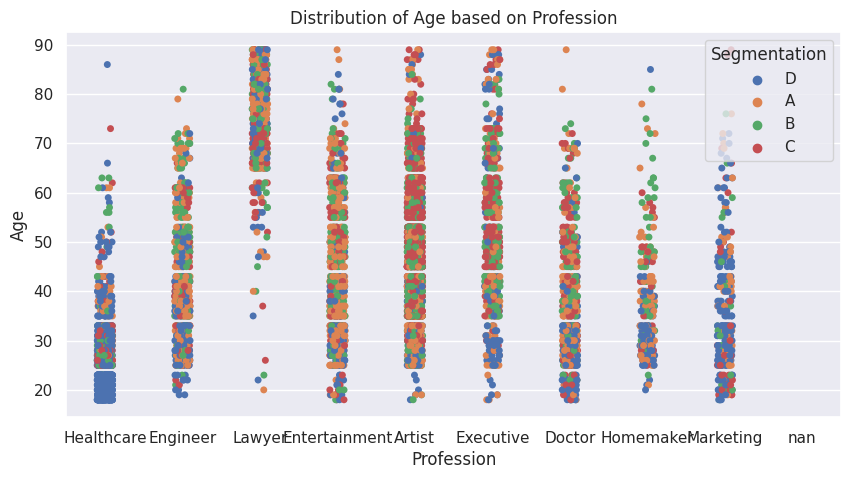

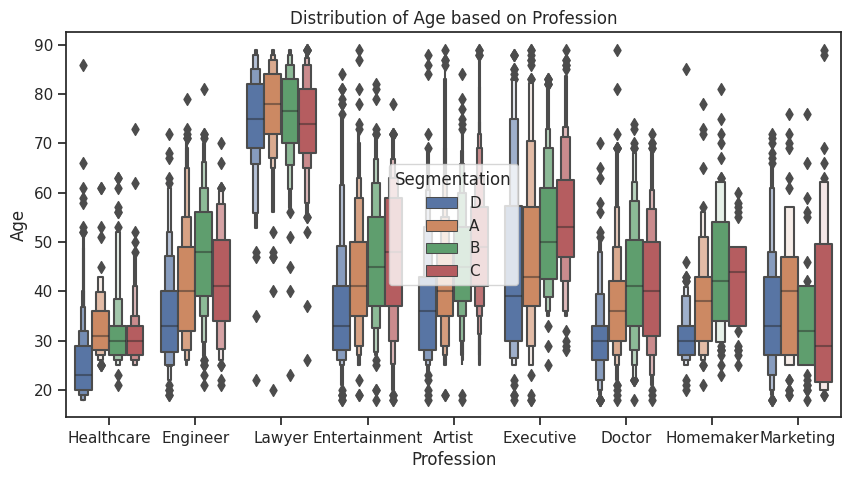

In [94]:
plot_category(categorical=traindt.Profession)

**Work Experience**

In [95]:
traindt.Work_Experience.unique()

array([ 1., nan,  0.,  4.,  9., 12.,  3., 13.,  5.,  8., 14.,  7.,  2.,
        6., 10., 11.])

**Spending Score**

In [96]:
traindt.Spending_Score.unique()

array(['Low', 'Average', 'High'], dtype=object)

In [97]:
pd.DataFrame(data=[(trainCluster[(traindt['Spending_Score'] == 'Low')].value_counts()/ trainCluster.value_counts()) * 100,
                   (trainCluster[(traindt['Spending_Score'] == 'Average')].value_counts()/ trainCluster.value_counts()) * 100,
                   (trainCluster[(traindt['Spending_Score'] == 'High')].value_counts()/ trainCluster.value_counts()) * 100],
             index=traindt.Spending_Score.unique())

,A,B,C,D
Low,68.864097,47.578041,33.604061,87.037037
Average,17.393509,31.754575,45.837563,6.084656
High,13.742394,20.667384,20.558376,6.878307


**Family Size**

In [98]:
traindt.Family_Size.unique()

array([ 4.,  3.,  1.,  2.,  6., nan,  5.,  8.,  7.,  9.])

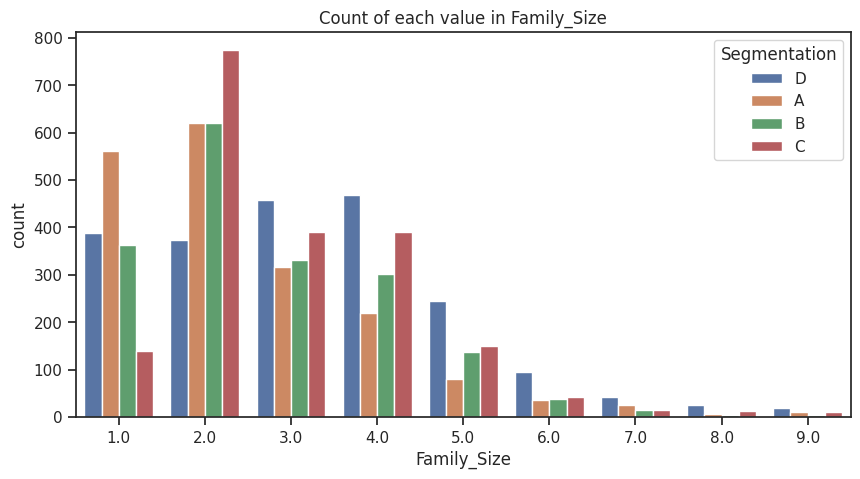

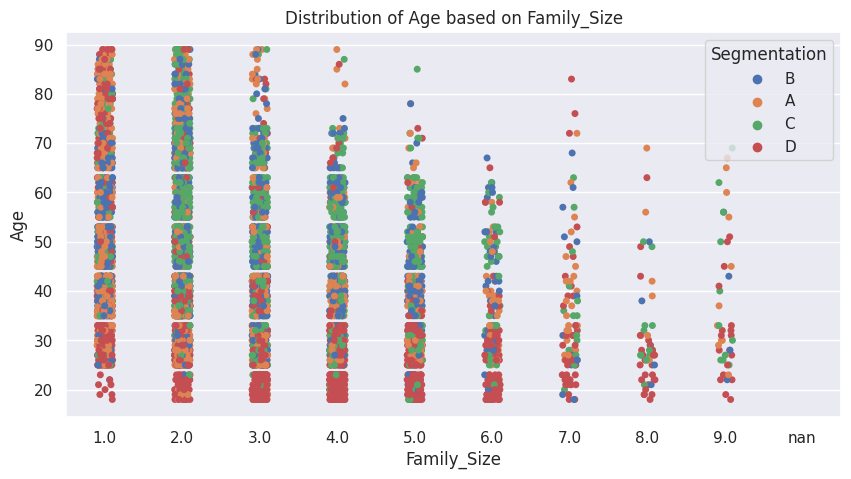

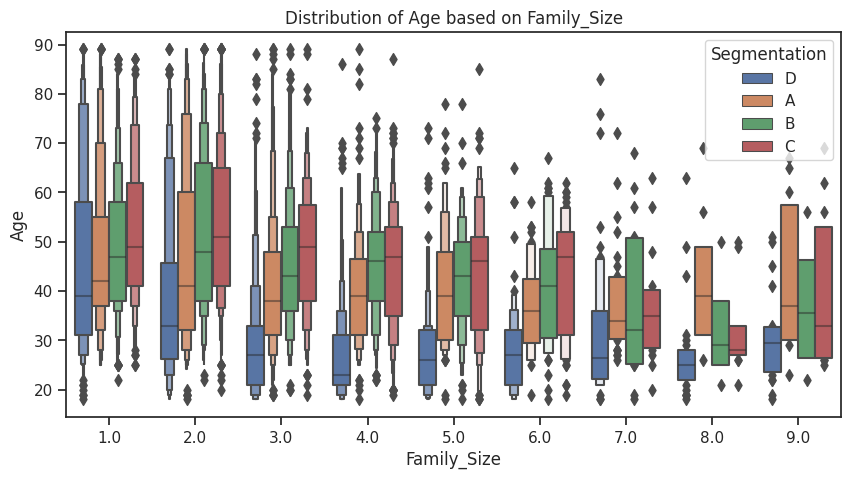

In [99]:
plot_category(categorical=traindt.Family_Size)

**Var 1**

In [100]:
traindt.Var_1.unique()

array(['Cat_4', 'Cat_6', 'Cat_7', 'Cat_3', 'Cat_1', 'Cat_2', nan, 'Cat_5'],
      dtype=object)

# **Preprocessing**

In [101]:
traindt = traindt.loc[:, ['Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Family_Size', 'Age']]
testdt = testdt.loc[:, ['Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Family_Size', 'Age']]

In [102]:
traindt.head()

,Ever_Married,Graduated,Profession,Spending_Score,Family_Size,Age
ID,,,,,,
462809,No,No,Healthcare,Low,4.0,22
462643,Yes,Yes,Engineer,Average,3.0,38
466315,Yes,Yes,Engineer,Low,1.0,67
461735,Yes,Yes,Lawyer,High,2.0,67
462669,Yes,Yes,Entertainment,High,6.0,40


**Missing Values**

In [103]:
traindt.isnull().sum()

Ever_Married      140
Graduated          78
Profession        124
Spending_Score      0
Family_Size       335
Age                 0
dtype: int64

In [104]:
testdt.isnull().sum()

Ever_Married       50
Graduated          24
Profession         38
Spending_Score      0
Family_Size       113
Age                 0
dtype: int64

In [105]:
traindt.groupby(['Ever_Married']).Graduated.value_counts()

Ever_Married  Graduated
No            Yes          1662
              No           1592
Yes           Yes          3240
              No           1360
Name: Graduated, dtype: int64

In [106]:
traindt.groupby(['Spending_Score']).Graduated.value_counts()

Spending_Score  Graduated
Average         Yes          1450
                No            503
High            Yes           780
                No            425
Low             Yes          2738
                No           2094
Name: Graduated, dtype: int64

In [107]:
traindt['Graduated'][(traindt['Graduated'].isnull()) &  (traindt['Spending_Score'] == 'Average')] = 'Yes'
traindt['Graduated'][(traindt['Graduated'].isnull())] = 'No'

testdt['Graduated'][(testdt['Graduated'].isnull()) &  (testdt['Spending_Score'] == 'Average')] = 'Yes'
testdt['Graduated'][(testdt['Graduated'].isnull())] = 'No'

<ipython-input-107-1fd8b7bef796>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traindt['Graduated'][(traindt['Graduated'].isnull()) &  (traindt['Spending_Score'] == 'Average')] = 'Yes'
<ipython-input-107-1fd8b7bef796>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traindt['Graduated'][(traindt['Graduated'].isnull())] = 'No'
<ipython-input-107-1fd8b7bef796>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testdt['Graduated'][(testd

In [108]:
traindt.groupby(['Spending_Score']).Family_Size.value_counts()

Spending_Score  Family_Size
Average         2.0             813
                3.0             451
                4.0             434
                5.0             164
                6.0              47
                7.0              14
                1.0               7
                9.0               7
                8.0               6
High            2.0             585
                3.0             230
                4.0             213
                5.0              88
                6.0              25
                1.0              17
                7.0              12
                9.0              11
                8.0               6
Low             1.0            1429
                2.0             992
                3.0             816
                4.0             732
                5.0             360
                6.0             140
                7.0              70
                8.0              38
                9.0              26


In [109]:
traindt.groupby(['Ever_Married']).Family_Size.value_counts()

Ever_Married  Family_Size
No            1.0             858
              3.0             630
              4.0             608
              2.0             453
              5.0             315
              6.0             120
              7.0              59
              8.0              36
              9.0              22
Yes           2.0            1909
              3.0             834
              4.0             749
              1.0             571
              5.0             284
              6.0              87
              7.0              36
              9.0              22
              8.0              12
Name: Family_Size, dtype: int64

In [110]:
traindt['Family_Size'][(traindt['Family_Size'].isnull()) & (traindt['Spending_Score'] == 'High')] = 2
traindt['Family_Size'][(traindt['Family_Size'].isnull()) & (traindt['Ever_Married'] == 'Yes')] = 2
traindt['Family_Size'][(traindt['Family_Size'].isnull()) & (traindt['Spending_Score'] == 'Low')] = 1

testdt['Family_Size'][(testdt['Family_Size'].isnull()) & (testdt['Spending_Score'] == 'High')] = 2
testdt['Family_Size'][(testdt['Family_Size'].isnull()) & (testdt['Ever_Married'] == 'Yes')] = 2
testdt['Family_Size'][(testdt['Family_Size'].isnull()) & (testdt['Spending_Score'] == 'Low')] = 1

<ipython-input-110-a7cef275f521>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traindt['Family_Size'][(traindt['Family_Size'].isnull()) & (traindt['Spending_Score'] == 'High')] = 2
<ipython-input-110-a7cef275f521>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traindt['Family_Size'][(traindt['Family_Size'].isnull()) & (traindt['Ever_Married'] == 'Yes')] = 2
<ipython-input-110-a7cef275f521>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

In [111]:
traindt.groupby(['Ever_Married']).Profession.value_counts()

Ever_Married  Profession   
No            Healthcare       1153
              Artist            713
              Doctor            366
              Entertainment     358
              Engineer          267
              Marketing         189
              Homemaker         112
              Lawyer             40
              Executive          37
Yes           Artist           1774
              Entertainment     579
              Lawyer            575
              Executive         550
              Engineer          415
              Doctor            311
              Healthcare        145
              Homemaker         128
              Marketing          96
Name: Profession, dtype: int64

In [112]:
traindt.groupby(['Spending_Score']).Profession.value_counts()

Spending_Score  Profession   
Average         Artist           1011
                Entertainment     319
                Engineer          221
                Doctor            177
                Executive          75
                Homemaker          60
                Healthcare         42
                Lawyer             18
                Marketing          17
High            Executive         398
                Lawyer            324
                Artist            242
                Engineer           60
                Entertainment      46
                Healthcare         45
                Marketing          33
                Doctor             31
                Homemaker          26
Low             Artist           1263
                Healthcare       1245
                Entertainment     584
                Doctor            480
                Engineer          418
                Lawyer            281
                Marketing         242
                Home

In [113]:
traindt['Profession'][(traindt['Profession'].isnull()) & ((traindt['Ever_Married'] == 'Yes') | (traindt['Spending_Score'] == 'Average'))] = 'Artist'
traindt['Profession'][(traindt['Profession'].isnull()) & (traindt['Ever_Married'] == 'No')] = 'Healthcare'
traindt['Profession'][(traindt['Profession'].isnull()) & (traindt['Spending_Score'] == 'High')] = 'Executive'

testdt['Profession'][(testdt['Profession'].isnull()) & ((testdt['Ever_Married'] == 'Yes') | (testdt['Spending_Score'] == 'Average'))] = 'Artist'
testdt['Profession'][(testdt['Profession'].isnull()) & (testdt['Ever_Married'] == 'No')] = 'Healthcare'
testdt['Profession'][(testdt['Profession'].isnull()) & (testdt['Spending_Score'] == 'High')] = 'Executive'

<ipython-input-113-e9f89ab6c0f9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traindt['Profession'][(traindt['Profession'].isnull()) & ((traindt['Ever_Married'] == 'Yes') | (traindt['Spending_Score'] == 'Average'))] = 'Artist'
<ipython-input-113-e9f89ab6c0f9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traindt['Profession'][(traindt['Profession'].isnull()) & (traindt['Ever_Married'] == 'No')] = 'Healthcare'
<ipython-input-113-e9f89ab6c0f9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [114]:
traindt['Ever_Married'].replace(np.nan, traindt['Ever_Married'].mode()[0], inplace=True)
testdt['Ever_Married'].replace(np.nan, testdt['Ever_Married'].mode()[0], inplace=True)

In [115]:
traindt.isnull().sum()

Ever_Married      0
Graduated         0
Profession        0
Spending_Score    0
Family_Size       0
Age               0
dtype: int64

In [116]:
testdt.isnull().sum()

Ever_Married      0
Graduated         0
Profession        0
Spending_Score    0
Family_Size       0
Age               0
dtype: int64

**Encodong**

In [117]:
traindt = pd.get_dummies(traindt, columns=['Ever_Married', 'Graduated', 'Profession'], drop_first=True)
traindt['Spending_Score'].replace(['Low', 'Average', 'High'], [0,1,2], inplace=True)

testdt = pd.get_dummies(testdt, columns=['Ever_Married', 'Graduated', 'Profession'], drop_first=True)
testdt['Spending_Score'].replace(['Low', 'Average', 'High'], [0,1,2], inplace=True)

In [118]:
trainCluster.replace(['A', 'B', 'C', 'D'], [0,1,2, 3], inplace=True)
testCluser.replace(['A', 'B', 'C', 'D'], [0,1,2, 3], inplace=True)

In [119]:
traindt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8068 entries, 462809 to 461879
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Spending_Score            8068 non-null   int64  
 1   Family_Size               8068 non-null   float64
 2   Age                       8068 non-null   int64  
 3   Ever_Married_Yes          8068 non-null   uint8  
 4   Graduated_Yes             8068 non-null   uint8  
 5   Profession_Doctor         8068 non-null   uint8  
 6   Profession_Engineer       8068 non-null   uint8  
 7   Profession_Entertainment  8068 non-null   uint8  
 8   Profession_Executive      8068 non-null   uint8  
 9   Profession_Healthcare     8068 non-null   uint8  
 10  Profession_Homemaker      8068 non-null   uint8  
 11  Profession_Lawyer         8068 non-null   uint8  
 12  Profession_Marketing      8068 non-null   uint8  
dtypes: float64(1), int64(2), uint8(10)
memory usage: 330.9 K

**Correlation**

<Axes: >

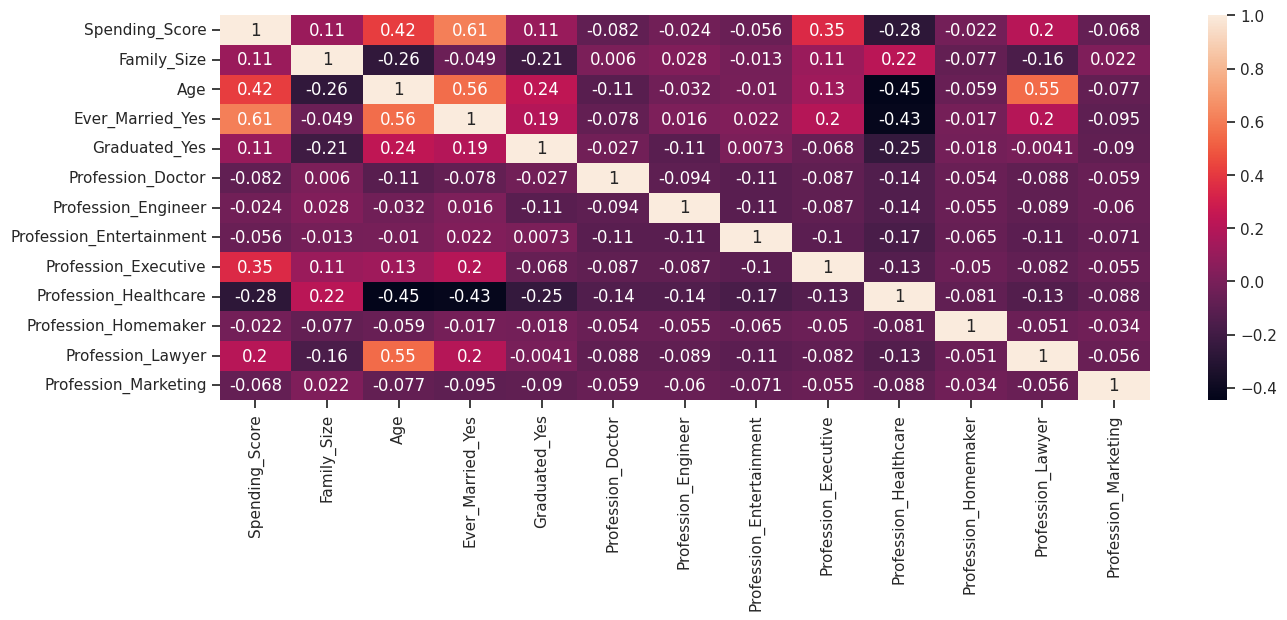

In [120]:
py.figure(figsize=(15,5))
sb.heatmap(traindt.corr(), annot=True)

# **Clustering Model**

In [121]:
random_state = 45
max_itr = 500

In [122]:
def kmean(traindt=traindt, actualClusters=trainCluster, testdt=testdt, testClusters=testCluser, type_='k-means++',  clusters=4):

    model = KMeans(n_clusters=clusters, init=type_, random_state=random_state, max_iter=max_itr)
    model.fit(traindt)
    preds = model.predict(traindt)
    preds_test = model.predict(testdt)

    print("silhouette score Train =", silhouette_score(traindt, preds))
    print("silhouette score Test = ", silhouette_score(testdt, preds_test))
    return preds, preds_test

In [123]:
preds_train_or, preds_test_or = kmean()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


silhouette score Train = 0.508249092499952
silhouette score Test =  0.5059655533603914


In [124]:
tsne = TSNE(random_state=random_state, init='pca')

In [125]:
low_dim_tsne = pd.DataFrame(tsne.fit_transform(traindt))
low_dim_tsne['Segmentation KMeans'] = preds_train_or

In [126]:
low_dim_tsne_test = pd.DataFrame(tsne.fit_transform(testdt))
low_dim_tsne_test['Segmentation KMeans'] = preds_test_or

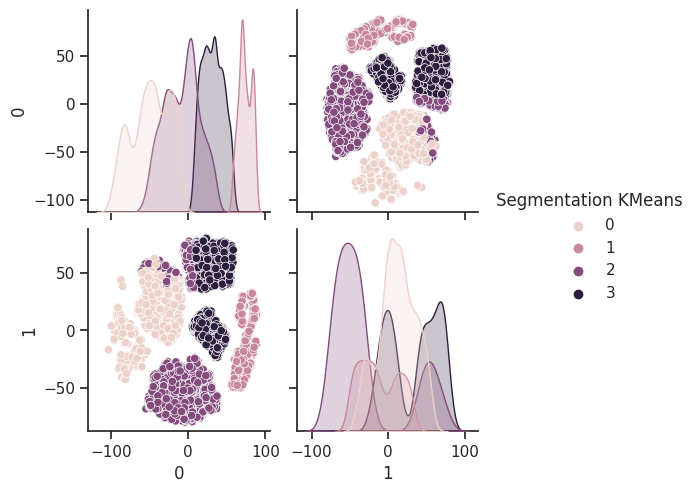

In [127]:
sb.pairplot(data=low_dim_tsne.loc[:, [0,1, 'Segmentation KMeans']], hue='Segmentation KMeans')

# **Classification Model**

In [128]:
def knn_fit(traindt=traindt, trainClasess=trainCluster, testdt=testdt, testClasses=testCluser):

    train_error, test_error = [], []

    for k in range(3, 12, 2):
      model = KNeighborsClassifier(n_neighbors=k)
      model.fit(traindt, trainClasess)
      train_error.append(np.mean(model.predict(traindt) != trainClasess.values))
      test_error.append(np.mean(model.predict(testdt) != testClasses.values))
      pass

    py.plot(range(3, 12, 2), train_error, label='Train Error')
    py.plot(range(3, 12, 2), test_error, label='Test Error')
    py.xlabel('K values')
    py.ylabel('Error')
    py.legend()
    py.show()
    pass

def knn_apply(k, traindt=traindt, trainClasess=trainCluster, testdt=testdt, testClasses=testCluser):


    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(traindt, trainClasess)

    preds_train = model.predict(traindt)
    print("In Train Set")
    print('\t\t Accuracy Score = ', accuracy_score(trainClasess, preds_train))
    ConfusionMatrixDisplay(confusion_matrix(trainClasess, preds_train)).plot()
    py.title("Display Confusion Matrix for Train Set")
    py.show()
    print('\t\t Classification Report = ', classification_report(trainClasess, preds_train))

    preds_test = model.predict(testdt)
    print("In Test Set")
    print('\t\t Accuracy Score = ', accuracy_score(testClasses, preds_test))
    ConfusionMatrixDisplay(confusion_matrix(testClasses, preds_test)).plot()
    py.title("Display Confusion Matrix for Test Set")
    py.show()
    print('\t\t Classification Report = ', classification_report(testClasses, preds_test))

    return model

In [129]:
def random_forest(traindt=traindt, trainClasess=trainCluster, testdt=testdt, testClasses=testCluser):

    model = RandomForestClassifier(random_state=random_state, n_estimators=300)
    model.fit(traindt, trainClasess)

    preds_train = model.predict(traindt)
    print("In Train Set")
    print('\t\t Accuracy Score = ', accuracy_score(trainClasess, preds_train))
    ConfusionMatrixDisplay(confusion_matrix(trainClasess, preds_train)).plot()
    py.title("Display Confusion Matrix for Train Set")
    py.show()
    print('\t\t Classification Report = ', classification_report(trainClasess, preds_train))

    preds_test = model.predict(testdt)
    print("In Test Set")
    print('\t\t Accuracy Score = ', accuracy_score(testClasses, preds_test))
    ConfusionMatrixDisplay(confusion_matrix(testClasses, preds_test)).plot()
    py.title("Display Confusion Matrix for Test Set")
    py.show()
    print('\t\t Classification Report = ', classification_report(testClasses, preds_test))

    return model

In [130]:
def svm(traindt=traindt, trainClasess=trainCluster, testdt=testdt, testClasses=testCluser):

    model = SVC(C=0.8, probability=True, kernel='linear', random_state=random_state, max_iter=max_itr)
    model.fit(traindt, trainClasess)

    preds_train = model.predict(traindt)
    print("In Train Set")
    print('\t\t Accuracy Score = ', accuracy_score(trainClasess, preds_train))
    ConfusionMatrixDisplay(confusion_matrix(trainClasess, preds_train)).plot()
    py.title("Display Confusion Matrix for Train Set")
    py.show()
    print('\t\t Classification Report = ', classification_report(trainClasess, preds_train))

    preds_test = model.predict(testdt)
    print("In Test Set")
    print('\t\t Accuracy Score = ', accuracy_score(testClasses, preds_test))
    ConfusionMatrixDisplay(confusion_matrix(testClasses, preds_test)).plot()
    py.title("Display Confusion Matrix for Test Set")
    py.show()
    print('\t\t Classification Report = ', classification_report(testClasses, preds_test))

    return model

In [131]:
def adaboost(traindt=traindt, trainClasess=trainCluster, testdt=testdt, testClasses=testCluser):

    model = AdaBoostClassifier(random_state=random_state, n_estimators=300)
    model.fit(traindt, trainClasess)

    preds_train = model.predict(traindt)
    print("In Train Set")
    print('\t\t Accuracy Score = ', accuracy_score(trainClasess, preds_train))
    ConfusionMatrixDisplay(confusion_matrix(trainClasess, preds_train)).plot()
    py.title("Display Confusion Matrix for Train Set")
    py.show()
    print('\t\t Classification Report = ', classification_report(trainClasess, preds_train))

    preds_test = model.predict(testdt)
    print("In Test Set")
    print('\t\t Accuracy Score = ', accuracy_score(testClasses, preds_test))
    ConfusionMatrixDisplay(confusion_matrix(testClasses, preds_test)).plot()
    py.title("Display Confusion Matrix for Test Set")
    py.show()
    print('\t\t Classification Report = ', classification_report(testClasses, preds_test))

    return model

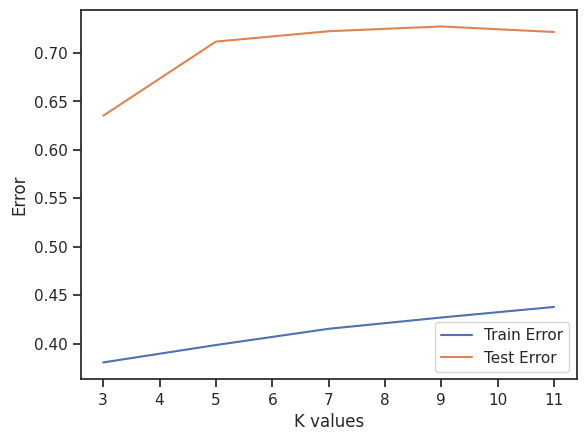

In [132]:
knn_fit()

In Train Set
		 Accuracy Score =  0.6015121467526029


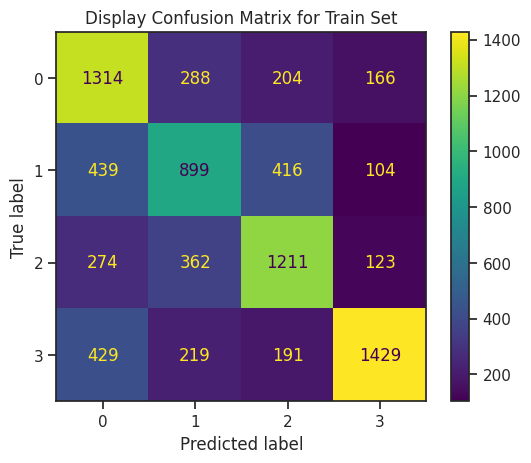

		 Classification Report =                precision    recall  f1-score   support

           0       0.54      0.67      0.59      1972
           1       0.51      0.48      0.50      1858
           2       0.60      0.61      0.61      1970
           3       0.78      0.63      0.70      2268

    accuracy                           0.60      8068
   macro avg       0.61      0.60      0.60      8068
weighted avg       0.61      0.60      0.60      8068

In Test Set
		 Accuracy Score =  0.2885420631899505


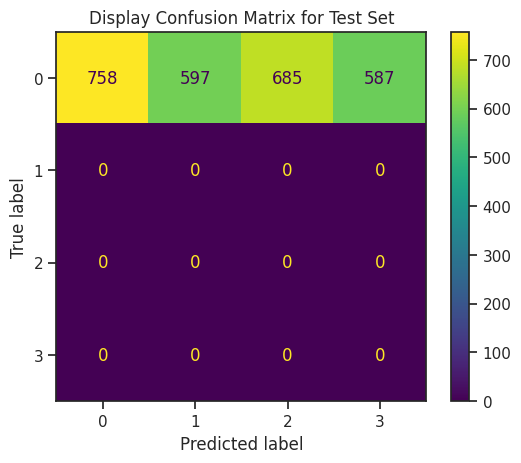

		 Classification Report =                precision    recall  f1-score   support

           0       1.00      0.29      0.45      2627
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0

    accuracy                           0.29      2627
   macro avg       0.25      0.07      0.11      2627
weighted avg       1.00      0.29      0.45      2627



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [133]:
knn_model = knn_apply(k=5)

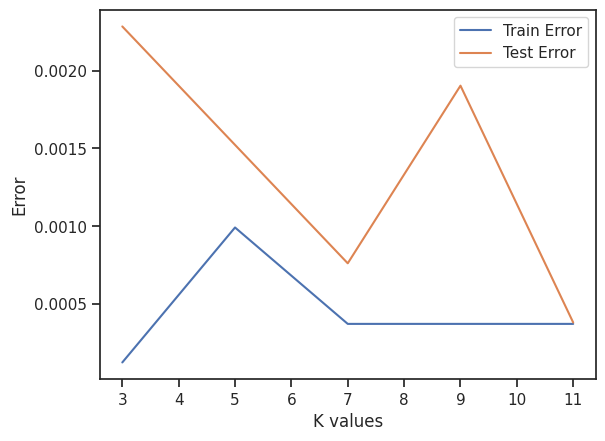

In [134]:
knn_fit(trainClasess=pd.Series(preds_train_or), testClasses=pd.Series(preds_test_or))

In Train Set
		 Accuracy Score =  0.9996281606346058


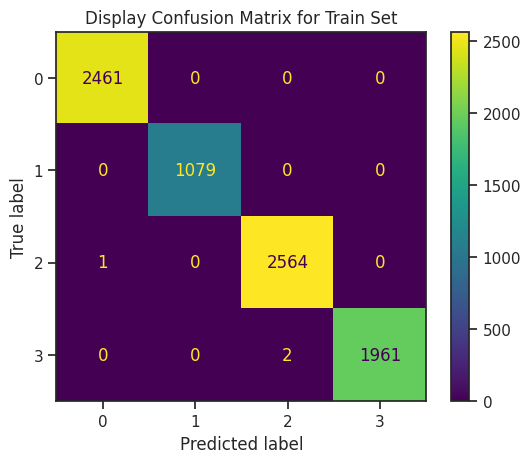

		 Classification Report =                precision    recall  f1-score   support

           0       1.00      1.00      1.00      2461
           1       1.00      1.00      1.00      1079
           2       1.00      1.00      1.00      2565
           3       1.00      1.00      1.00      1963

    accuracy                           1.00      8068
   macro avg       1.00      1.00      1.00      8068
weighted avg       1.00      1.00      1.00      8068

In Test Set
		 Accuracy Score =  0.9996193376475067


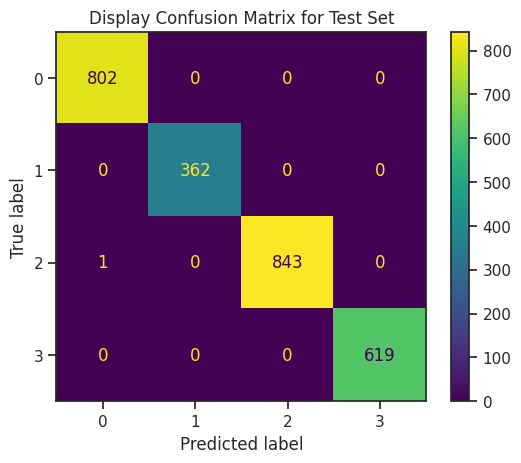

		 Classification Report =                precision    recall  f1-score   support

           0       1.00      1.00      1.00       802
           1       1.00      1.00      1.00       362
           2       1.00      1.00      1.00       844
           3       1.00      1.00      1.00       619

    accuracy                           1.00      2627
   macro avg       1.00      1.00      1.00      2627
weighted avg       1.00      1.00      1.00      2627



In [135]:
knn_model = knn_apply(k=11, trainClasess=pd.Series(preds_train_or), testClasses=pd.Series(preds_test_or))